In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math

# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import polymer, distances, rdf

### Calculate radius of gyration and persistence length of PLGA/water simulations

In [4]:
def seg_org(poly_atoms, n_monomers):
    
    pmecl = []
    count = 0
    for i in range(n_monomers):
        fgrp = []
        count += 1
        n_atm = len(poly_atoms.select_atoms("resid "+str(count)))
        
        if count == 1:
            #print(poly_atoms.select_atoms("resid "+str(count)+" and name O13"))
            pmecl.append(poly_atoms.select_atoms("resid "+str(count)+" and (name O13 O9)"))
            #print(pmecl)
        elif count == 2:
            #print(poly_atoms.select_atoms("name O5 and resid "+str(count)))
            pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O5) or (resid "+str(count-1)+" and name O9)"))
        
        if count != 2 and count != 1:
            if count == n_monomers:
                pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O1) or (resid "+str(count-1)+" and name O5)"))
            elif count != n_monomers:
            #print(count)
                pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O5) or (resid "+str(count-1)+" and name O5)"))

    return pmecl

In [5]:
# write function to average across frames to give ensembled averaged correlation values at each nl value
# write function to average across frames to give ensembled averaged correlation values at each nl value

def pers_length(polymer_atoms, n_monomers):
    
    vec_poly = np.zeros(shape=(3,n_monomers-1), dtype=float)
    
    len_vec = np.arange(n_monomers-1)
    
    len_vec += 1

    vec_poly[1,:] = len_vec

    count = 0 
    
    sv_ply = np.zeros(shape=(n_monomers-1), dtype=object)
    
    for i in range(n_monomers):
        
        count += 1
        
        ds_cor = np.zeros(shape=(n_monomers-count))
        
        for j in range(n_monomers - count):
        
            jh = np.arange(n_monomers - count)
            
            jh += count+1

            n6_mon1 = polymer_atoms.select_atoms("resid "+str(count))

            n6_mon2 = polymer_atoms.select_atoms("resid "+str(jh[j]))

            if j == 0: 
                    
                v1 = n6_mon1.center_of_mass() - n6_mon2.center_of_mass()
                    
                v1_norm = v1/(np.linalg.norm(v1))
            
                ds_cor[j] = v1_norm.dot(v1_norm)

            elif j != 0:
                    
                v2 = n6_mon1.center_of_mass() - n6_mon2.center_of_mass()
                    
                v2_norm = v2/(np.linalg.norm(v2))
                
                ds_cor[j] = np.dot(v1_norm, v2_norm)

            sv_ply[i] = ds_cor
    
    cor_avg = []
    
    for j in range(n_monomers-1):
        lss = []
        for i in sv_ply.flat:
            try:
                lss.append(i[j])
            except IndexError:
                pass
        cor_avg.append(np.mean(lss))
    
    nm = np.array(cor_avg)
    
    ang_vg = []
    for i in nm.flat:
        if i >= float(0.99):
            ang_vg.append(0)
        elif i <= float(0.99):
            ang_vg.append(math.degrees(math.acos(i)))

    vec_poly[0,:] = nm 
    vec_poly[2,:] = np.array(ang_vg)
    
    return vec_poly

In [6]:
def get_rg_pers_poly(polymer_atoms, universe, start, end, ln_bnd):
    """This function will calculate the average radius of gyration and persistence length of a polymer within a 
    trajectory block."""
    
    n_monomers = len(np.unique(polymer_atoms.resids))
    
    rg_ens = np.zeros(shape=(1,end-start))
    
    corr_v = np.zeros(shape=(n_monomers-1,end-start))
    
    angle_v = np.zeros(shape=(n_monomers-1,end-start))
    
    v_poly = np.zeros(shape=(3,n_monomers-1))
    
    count_rg = 0
    
    universe.trajectory[start]
    
    for ts in universe.trajectory[start:end]:
        
        p_mat = pers_length(polymer_atoms, n_monomers)
     
        corr_v[:,count_rg] = p_mat[0,:]
        
        angle_v[:,count_rg] = p_mat[2,:]
        
        rg_ens[0,count_rg] = polymer_atoms.radius_of_gyration()
        
        count_rg += 1 
        
        universe.trajectory[end]
    
    v_poly[2,:] = p_mat[1,:]
    
    for i in range(n_monomers-1):
        
        v_poly[0,i] = np.mean(corr_v[i,:])
        
        v_poly[1,i] = np.mean(angle_v[i,:])
     
    avg_rg = np.mean(rg_ens)
    
    def expfunc(x, a):
        return np.exp(-x*ln_bnd/a)
    # Starting with x = 0 for fits
    tr_n6 = np.arange(n_monomers-1)
    
    #tr_n6 += 1

    pers_lp = scipy.optimize.curve_fit(expfunc, tr_n6, v_poly[0,:])[0][0]
    
    return  rg_ens, v_poly, pers_lp, avg_rg

In [7]:
# I want a list of total fraction of contacts where length is determined by no. of blocks and a dictionary 
# of contact groups as keys and list of fractional contacts as values(length of list will be no. of blocks)
def bavg_pers_cnt(no_of_blks, polymer_atoms, universe, len_bnd, begin, final):
 
    n_size = (final - begin)/no_of_blks
    
    ot_dab = {}
    universe.trajectory[begin]
    
    sf_lbl = ["Avg Radius of gyration", "Avg persistence length"]

    blk_nparr = np.zeros(shape=(len(sf_lbl),no_of_blks))
    
    count = 0 
    
    for i in range(no_of_blks):
        
        start = universe.trajectory.frame
        print(start)
    
        end = int(start + n_size)
        print(end)
       
        pp_rgens, cor_pp, per_pp, rg_avgpp = get_rg_pers_poly(polymer_atoms, universe, start, end, len_bnd)
        
        blk_nparr[0,count] = rg_avgpp
        
        blk_nparr[1,count] = per_pp        
        
        universe.trajectory[end]
        
        count += 1
    # Save fractional contacts for each AA group type, each element in the value array corresponds to a block 
    # calculated value
    for i in range(len(sf_lbl)):
        ot_dab[sf_lbl[i]] = blk_nparr[i,:]
    
    return ot_dab
        

### Water only systems

## N = 6 water

In [8]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n6_plga_wat = mda.Universe("n6_plga_50ns/0_xa_soln/confout.gro", "n6_plga_50ns/0_xa_soln/nopbc_n6wat.xtc")

In [9]:
len(n6_plga_wat.trajectory)

5001

In [10]:
#Select the polymer heavy atoms 
poly_n6 = n6_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
o9_atom = poly_n6.select_atoms("resid 1 and name O9")
o5_plg1 = poly_n6.select_atoms("resid 2 and name O5")
lbond = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_wat.trajectory[0:5000]:
    oo_len = mda.analysis.distances.distance_array(o9_atom.positions, o5_plg1.positions, 
                                                   box=n6_plga_wat.trajectory.ts.dimensions)
    lbond[0, count] = oo_len
    count += 1

#lbond
#lb_avg = np.mean(lbond)
plt.scatter(np.arange(5000),lbond)

In [ ]:
list(poly_n6)

In [ ]:
poly_n6.center_of_mass()

In [ ]:
n6_plga_wat.select_atoms("resid 1").center_of_mass()

In [ ]:
list(n6_plga_wat.select_atoms("resid 1"))

In [ ]:
n_monomers = len(np.unique(poly_n6.resids))
com_pos_n6 = np.zeros(shape=(n_monomers), dtype=object)
for i in range(n_monomers):
    #print(i)
    #print(n6_plga_wat.select_atoms("resid "+str(i+1)).center_of_mass())
    com_pos_n6[i] = n6_plga_wat.select_atoms("resid "+str(i+1)).center_of_mass()
com_pos_n6

In [11]:
com_bond = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_wat.trajectory[0:5000]:
    n6_mon1 = n6_plga_wat.select_atoms("resid 1")
    n6_mon2 = n6_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1.center_of_mass(), n6_mon2.center_of_mass(), 
                                                   box=n6_plga_wat.trajectory.ts.dimensions)
    com_bond[0, count] = oo_len
    count += 1
    

In [12]:
com_bond

array([[5.41774043, 4.78879205, 5.54438067, ..., 6.56805096, 6.42530086,
        6.30959793]])

In [13]:
lb_avg = np.mean(com_bond)
lb_avg

5.691897446005937

In [14]:
np.std(com_bond)

0.7661117243666821

In [ ]:
np.mean(lbond)

In [ ]:
np.std(lbond)

In [ ]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),lbond,c="y")

In [16]:
lb_avg

5.691897446005937

In [17]:
n6_blks = bavg_pers_cnt(5, poly_n6, n6_plga_wat, lb_avg, 0 , 5000)

0
1000
1000
2000
2000
3000
3000
4000
4000
5000


In [18]:
# Fully extended length of 6 monomer PLGA is 3.838 nm 
n6_blks["Avg persistence length"]

array([13.35953028, 25.66983957, 16.62803879, 19.41697775, 18.9121992 ])

In [19]:
n6_blks["Avg Radius of gyration"]

array([5.68487411, 6.1564806 , 5.81737282, 5.54520295, 5.75495092])

In [20]:
np.mean(n6_blks["Avg persistence length"])

18.797317117752463

In [21]:
np.std(n6_blks["Avg persistence length"])

4.047320994507758

In [22]:
n6_rgens, cor_n6, pers_n6, rg_avgn6 = get_rg_pers_poly(poly_n6, n6_plga_wat, 0, 5000, lb_avg)

In [23]:
cor_n6

array([[ 1.        ,  0.75288193,  0.49128594,  0.37804014,  0.3226647 ],
       [ 0.        , 40.80351103, 59.95608195, 66.45823909, 68.49624104],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ]])

In [24]:
cor_n6[0]

array([1.        , 0.75288193, 0.49128594, 0.37804014, 0.3226647 ])

In [25]:
pers_n6

18.133095102842137

In [ ]:
lb_avg

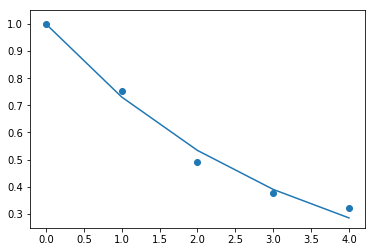

In [26]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)
nt = np.arange(5)
#nt += 1
plt.scatter(nt, cor_n6[0,:])
# a-axis is the number of bond lengths away 
plt.plot(nt,exfun(nt, pers_n6))

In [ ]:
rg_n6 = np.zeros(shape=(5000))

count = 0
for ts in n6_plga_wat.trajectory[0:5000]:

    rg_n6[count] = poly_n6.radius_of_gyration()
    
    count += 1
    
tr_n6 = np.arange(5000)   
plt.figure(figsize=(8,8))
plt.scatter(tr_n6,rg_n6/10)

## N = 8 water

In [27]:
n8_plga_wat = mda.Universe("n8_plga_50ns/0_xa_soln/confout.gro", "n8_plga_50ns/0_xa_soln/nopbc_traj.xtc")

In [28]:
n8_plga_wat

<Universe with 12609 atoms>

In [29]:
#Select the polymer heavy atoms 
poly_n8 = n8_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [30]:
len(n8_plga_wat.trajectory)

5001

In [ ]:
list(o5_plg1)

In [31]:
com_bond_n8 = np.zeros(shape=(1,5000))
count = 0
for ts in n8_plga_wat.trajectory[0:5000]:
    n8_mon1 = n8_plga_wat.select_atoms("resid 1")
    n8_mon2 = n8_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1.center_of_mass(), n8_mon2.center_of_mass(), 
                                                   box=n8_plga_wat.trajectory.ts.dimensions)
    com_bond_n8[0, count] = oo_len
    count += 1
lb_avg_n8 = np.mean(com_bond_n8)

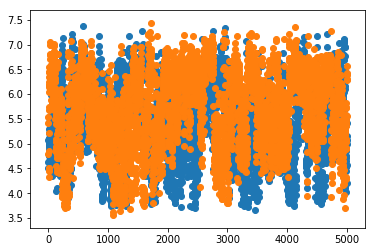

In [32]:
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond)

In [33]:
lb_avg_n8

5.419908626450464

In [34]:
lb_avg

5.691897446005937

In [35]:
n8_blks = bavg_pers_cnt(5, poly_n8, n8_plga_wat, lb_avg, 0 , 5000)

0
1000
1000
2000
2000
3000
3000
4000
4000
5000


In [36]:
n8_blks["Avg persistence length"]

array([20.81153715, 18.81189265, 16.59988721, 19.16383021, 22.5722986 ])

In [37]:
n8_blks["Avg Radius of gyration"]

array([7.02121637, 6.82745788, 6.71821951, 6.66298761, 6.58102339])

In [38]:
n8_rgens, cor_n8_mat, pers_n8, rg_avgn8 = get_rg_pers_poly(poly_n8, n8_plga_wat, 0, 5000, lb_avg)

In [40]:
cor_n8_mat

array([[ 1.        ,  0.78399787,  0.52602686,  0.3728495 ,  0.27791177,
         0.2309618 ,  0.27003583],
       [ 0.        , 38.14413057, 57.90990267, 67.50218156, 72.85869348,
        75.24013707, 71.93114384],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ]])

In [41]:
cor_n8_mat[0]

array([1.        , 0.78399787, 0.52602686, 0.3728495 , 0.27791177,
       0.2309618 , 0.27003583])

In [42]:
pers_n8

19.454786238445518

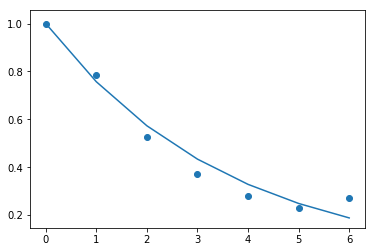

In [44]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n8/a)

nt = np.arange(7)
plt.scatter(nt, cor_n8_mat[0,:])
plt.plot(nt,exfun(nt, pers_n8))

In [45]:
np.mean(n8_blks["Avg persistence length"])

19.591889167033475

In [46]:
np.std(n8_blks["Avg persistence length"])

2.0056962053539937

## N = 10 water

In [47]:
n10_plga_wat = mda.Universe("n10_plga_50ns/0_xa_soln/N10_sys.gro", "n10_plga_50ns/0_xa_soln/nopbc_10wat.xtc")

In [48]:
n10_plga_wat

<Universe with 153 atoms>

In [49]:
len(n10_plga_wat.trajectory)

5001

In [50]:
poly_n10 = n10_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [51]:
com_bond_n10 = np.zeros(shape=(1,5000))
count = 0
for ts in n10_plga_wat.trajectory[0:5000]:
    n10_mon1 = n10_plga_wat.select_atoms("resid 1")
    n10_mon2 = n10_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1.center_of_mass(), n10_mon2.center_of_mass(), 
                                                   box=n10_plga_wat.trajectory.ts.dimensions)
    com_bond_n10[0, count] = oo_len
    count += 1
lb_avg_n10 = np.mean(com_bond_n10)

In [52]:
lb_avg_n10

5.591477567959724

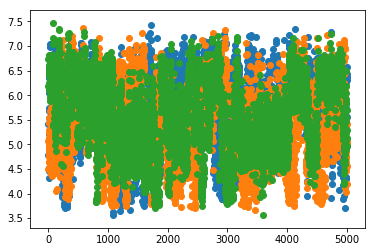

In [53]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond_n10)

In [54]:
lb_avg

5.691897446005937

In [55]:
n10_blks = bavg_pers_cnt(5, poly_n10, n10_plga_wat, lb_avg_n10, 0 , 5000)

0
1000
1000
2000
2000
3000
3000
4000
4000
5000


In [56]:
# Extended Length of 10 monomer length plga: 6.436 nm 
n10_blks["Avg persistence length"]

array([34.19594369, 17.2256789 , 22.02422702, 13.59196077, 14.25164986])

In [57]:
n10_blks["Avg Radius of gyration"]

array([6.9883839 , 7.00428414, 7.00107681, 6.92554125, 7.34435911])

In [80]:
np.mean(n10_blks["Avg Radius of gyration"])

7.05272904253288

In [81]:
np.std(n10_blks["Avg Radius of gyration"])

0.14857993640562434

In [58]:
np.mean(n10_blks["Avg persistence length"])

20.25789204787856

In [59]:
np.std(n10_blks["Avg persistence length"])

7.577507825399283

In [75]:
n10_rgens, cor_n10_mat, pers_n10, rg_avgn10 = get_rg_pers_poly(poly_n10, n10_plga_wat, 0, 1000, lb_avg)

In [76]:
cor_n10_mat

array([[ 1.        ,  0.76945457,  0.5326745 ,  0.37166219,  0.27003924,
         0.43685752,  0.53919603,  0.58387418,  0.43219679],
       [ 0.        , 39.56966549, 57.57482434, 67.7733684 , 73.91994728,
        63.70777755, 56.48306924, 52.56336291, 61.39770917],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        ]])

In [77]:
cor_n10_mat[0]

array([1.        , 0.76945457, 0.5326745 , 0.37166219, 0.27003924,
       0.43685752, 0.53919603, 0.58387418, 0.43219679])

In [78]:
pers_n10

34.810101873821594

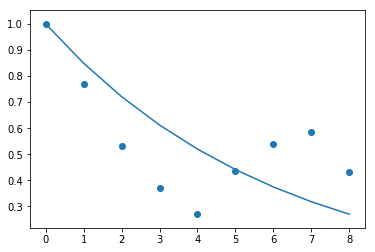

In [79]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(9)
plt.scatter(nt, cor_n10_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10))

## N = 20 water 

In [82]:
n20_plga_wat = mda.Universe("n20_plga_150ns/0_xa_soln/nowat_n20.gro", "n20_plga_150ns/0_xa_soln/N20_nopbcpp.xtc")

In [83]:
n20_plga_wat

<Universe with 303 atoms>

In [84]:
len(n20_plga_wat.trajectory)

15001

In [85]:
poly_n20 = n20_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [90]:
com_bond_n20 = np.zeros(shape=(1,15000))
count = 0
for ts in n20_plga_wat.trajectory[0:15000]:
    n20_mon1 = n20_plga_wat.select_atoms("resid 1")
    n20_mon2 = n20_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1.center_of_mass(), n20_mon2.center_of_mass(), 
                                                   box=n20_plga_wat.trajectory.ts.dimensions)
    com_bond_n20[0, count] = oo_len
    count += 1
lb_avg_n20 = np.mean(com_bond_n20)

In [91]:
lb_avg_n20

5.5775064834288015

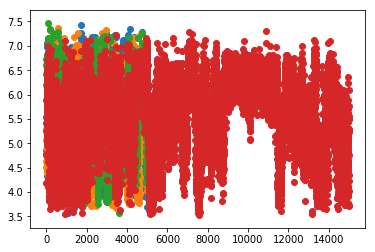

In [92]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond_n10)
plt.scatter(np.arange(15000),com_bond_n20)

In [93]:
n20_blks = bavg_pers_cnt(5, poly_n20, n20_plga_wat, lb_avg, 0 , 15000)

0
3000
3000
6000
6000
9000
9000
12000
12000
15000


In [94]:
n20_blks["Avg persistence length"]

array([34.69431752, 23.29780656, 26.96079047, 21.80901165, 24.78756503])

In [95]:
n20_blks["Avg Radius of gyration"]

array([9.95303181, 8.69824583, 9.06790532, 8.61729467, 8.63440246])

In [96]:
np.mean(n20_blks["Avg Radius of gyration"])

8.994176018924986

In [97]:
np.std(n20_blks["Avg Radius of gyration"])

0.5067330015067025

In [98]:
np.mean(n20_blks["Avg persistence length"])

26.309898247251038

In [99]:
np.std(n20_blks["Avg persistence length"])

4.524827556553603

In [100]:
n20_rgens, cor_n20_mat, pers_n20, rg_avgn20 = get_rg_pers_poly(poly_n20, n20_plga_wat, 0, 15000, lb_avg)

In [101]:
cor_n20_mat

array([[ 1.        ,  0.80423447,  0.55539194,  0.41054987,  0.31534959,
         0.23435083,  0.16010671,  0.12157466,  0.12921006,  0.1538862 ,
         0.18659722,  0.21416563,  0.23204986,  0.21960973,  0.18604922,
         0.20922653,  0.28672631,  0.29669197,  0.27354845],
       [ 0.        , 36.39754524, 56.18194291, 65.68154188, 71.51601712,
        76.3261191 , 80.65647296, 82.90401617, 82.47815405, 81.04417791,
        79.08707168, 77.34077051, 76.12939624, 76.82420456, 78.85747498,
        77.5528042 , 72.27061942, 71.14782083, 71.56464998],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        , 10.        ,
        11.        , 12.        , 13.        , 14.        , 15.        ,
        16.        , 17.        , 18.        , 19.        ]])

In [102]:
cor_n20_mat[0]

array([1.        , 0.80423447, 0.55539194, 0.41054987, 0.31534959,
       0.23435083, 0.16010671, 0.12157466, 0.12921006, 0.1538862 ,
       0.18659722, 0.21416563, 0.23204986, 0.21960973, 0.18604922,
       0.20922653, 0.28672631, 0.29669197, 0.27354845])

In [103]:
pers_n20

25.98052363916332

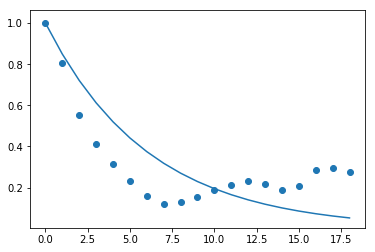

In [104]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(19)
plt.scatter(nt, cor_n20_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10))

## N= 30 water

In [105]:
n30_plga_wat = mda.Universe("n30_plga_150ns/0_xa_soln/0xa_n30sys.gro", "n30_plga_150ns/0_xa_soln/N30_nopbcpp_0xa.xtc")

In [106]:
n30_plga_wat

<Universe with 453 atoms>

In [107]:
len(n30_plga_wat.trajectory)

15001

In [108]:
poly_n30 = n30_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [109]:
com_bond_n30 = np.zeros(shape=(1,15000))
count = 0
for ts in n30_plga_wat.trajectory[0:15000]:
    n30_mon1 = n30_plga_wat.select_atoms("resid 1")
    n30_mon2 = n30_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1.center_of_mass(), n30_mon2.center_of_mass(), 
                                                   box=n30_plga_wat.trajectory.ts.dimensions)
    com_bond_n30[0, count] = oo_len
    count += 1
lb_avg_n30 = np.mean(com_bond_n30)

In [110]:
lb_avg_n30

5.60743077731889

In [111]:
n30_blks = bavg_pers_cnt(5, poly_n30, n30_plga_wat, lb_avg, 0 , 15000)

0
3000
3000
6000
6000
9000
9000
12000
12000
15000


In [112]:
n30_blks["Avg persistence length"]

array([32.63522312, 29.97753057, 31.32750661, 30.11556939, 31.07622999])

In [113]:
n30_blks["Avg Radius of gyration"]

array([10.42438921,  9.67932369,  9.43841575,  9.34253934,  9.50886734])

In [114]:
np.mean(n30_blks["Avg persistence length"])

31.026411936613023

In [115]:
np.std(n30_blks["Avg persistence length"])

0.9603332265572023

In [116]:
n30_rgens, cor_n30_mat, pers_n30, rg_avgn30 = get_rg_pers_poly(poly_n30, n30_plga_wat, 0, 15000, lb_avg)

In [117]:
cor_n30_mat

array([[1.00000000e+00, 8.01626939e-01, 5.59763947e-01, 4.07940544e-01,
        2.88477954e-01, 2.06676644e-01, 1.97395011e-01, 2.09132854e-01,
        2.29247162e-01, 2.47037369e-01, 2.49057984e-01, 2.39151258e-01,
        2.24639612e-01, 1.91803437e-01, 1.55606314e-01, 1.17348345e-01,
        1.12893213e-01, 9.84067596e-02, 8.31411003e-02, 1.08596298e-01,
        1.75853043e-01, 2.51029805e-01, 2.75093507e-01, 2.78997503e-01,
        2.66341322e-01, 2.34591619e-01, 3.10879373e-01, 3.35070997e-01,
        3.44840391e-01],
       [0.00000000e+00, 3.66508961e+01, 5.58993001e+01, 6.58826080e+01,
        7.31876637e+01, 7.80189239e+01, 7.85463415e+01, 7.78288806e+01,
        7.66366999e+01, 7.56325246e+01, 7.55190462e+01, 7.60500673e+01,
        7.68518749e+01, 7.88477095e+01, 8.10073063e+01, 8.32248438e+01,
        8.34690882e+01, 8.42930854e+01, 8.51716445e+01, 8.36981857e+01,
        7.96983276e+01, 7.51861776e+01, 7.35955717e+01, 7.33650854e+01,
        7.41638569e+01, 7.60453092e+01,

In [118]:
cor_n30_mat[0]

array([1.        , 0.80162694, 0.55976395, 0.40794054, 0.28847795,
       0.20667664, 0.19739501, 0.20913285, 0.22924716, 0.24703737,
       0.24905798, 0.23915126, 0.22463961, 0.19180344, 0.15560631,
       0.11734835, 0.11289321, 0.09840676, 0.0831411 , 0.1085963 ,
       0.17585304, 0.2510298 , 0.27509351, 0.2789975 , 0.26634132,
       0.23459162, 0.31087937, 0.335071  , 0.34484039])

In [119]:
pers_n30

30.976101435323606

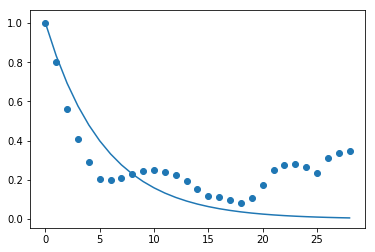

In [120]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(29)
plt.scatter(nt, cor_n30_mat[0,:])
plt.plot(nt,exfun(nt, pers_n30))

### Acetone systems only

## N = 6 acetone

In [8]:
n6_plga_ace = mda.Universe("n6_plga_50ns/1_xa_soln/confout.gro", "n6_plga_50ns/1_xa_soln/nopbc_n6ace.xtc")

In [9]:
n6_plga_ace

<Universe with 15093 atoms>

In [10]:
len(n6_plga_ace.trajectory)

5001

In [11]:
poly_n6_ace = n6_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [14]:
com_bond_n6ace = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_ace.trajectory[0:5000]:
    n6_mon1 = n6_plga_ace.select_atoms("resid 1")
    n6_mon2 = n6_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1.center_of_mass(), n6_mon2.center_of_mass(), 
                                                   box=n6_plga_ace.trajectory.ts.dimensions)
    com_bond_n6ace[0, count] = oo_len
    count += 1
lb_avg_n6ace = np.mean(com_bond_n6ace)

In [15]:
lb_avg_n6ace

5.986551142328634

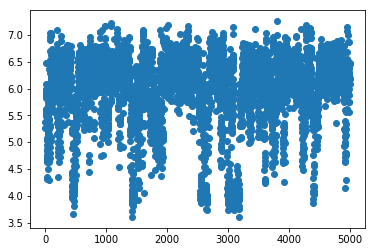

In [16]:
plt.scatter(np.arange(5000),com_bond_n6ace)


In [17]:
n6_blks_ace = bavg_pers_cnt(5, poly_n6_ace, n6_plga_ace, lb_avg_n6ace, 0 , 5000)

0
1000
1000
2000
2000
3000
3000
4000
4000
5000


In [18]:
n6_blks_ace["Avg persistence length"]

array([38.21099601, 36.5772936 , 55.28779412, 38.84234093, 47.19506294])

In [19]:
n6_blks_ace["Avg Radius of gyration"]

array([8.21601192, 8.25445851, 8.26136051, 8.28788101, 7.71302458])

In [20]:
np.mean(n6_blks_ace["Avg persistence length"])

43.22269751744368

In [21]:
np.std(n6_blks_ace["Avg persistence length"])

7.068413005806767

In [22]:
np.mean(n6_blks_ace["Avg Radius of gyration"])

8.14654730380919

In [24]:
np.std(n6_blks_ace["Avg Radius of gyration"])

0.21797678811081966

In [25]:
n6_rgens_ace, cor_n6ace_mat, pers_n6ace, rg_avgnace = get_rg_pers_poly(poly_n6_ace, n6_plga_ace, 0, 5000, lb_avg_n6ace)

In [26]:
cor_n6ace_mat

array([[ 1.        ,  0.88803885,  0.76668037,  0.66379561,  0.54295641],
       [ 0.        , 26.58478387, 38.23137142, 45.65927884, 52.35081927],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ]])

In [27]:
cor_n6ace_mat[0]

array([1.        , 0.88803885, 0.76668037, 0.66379561, 0.54295641])

In [28]:
pers_n6ace

42.30301715581782

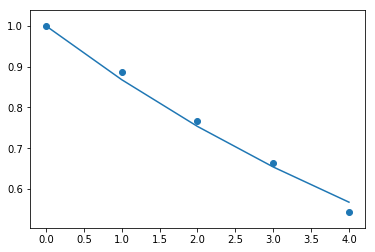

In [30]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(5)
plt.scatter(nt, cor_n6ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n6ace))

## N = 8 acetone

In [31]:
n8_plga_ace = mda.Universe("n8_plga_50ns/1_xa_soln/confout.gro", "n8_plga_50ns/1_xa_soln/nopbc_n8ace.xtc")

In [32]:
n8_plga_ace

<Universe with 15123 atoms>

In [33]:
len(n8_plga_ace.trajectory)

5001

In [34]:
poly_n8_ace = n8_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [38]:
com_bond_n8ace = np.zeros(shape=(1,5000))
count = 0
for ts in n8_plga_ace.trajectory[0:5000]:
    n8_mon1 = n8_plga_ace.select_atoms("resid 1")
    n8_mon2 = n8_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1.center_of_mass(), n8_mon2.center_of_mass(), 
                                                   box=n8_plga_ace.trajectory.ts.dimensions)
    com_bond_n8ace[0, count] = oo_len
    count += 1
lb_avg_n8ace = np.mean(com_bond_n8ace)

In [39]:
lb_avg_n8ace

6.136198777572896

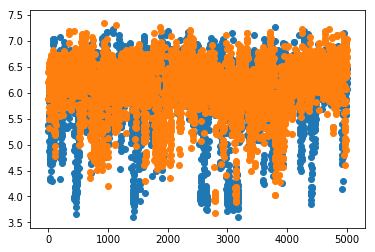

In [41]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)

In [44]:
n8_blks_ace = bavg_pers_cnt(5, poly_n8_ace, n8_plga_ace, lb_avg_n6ace, 0 , 5000)

0
1000
1000
2000
2000
3000
3000
4000
4000
5000


In [45]:
n8_blks_ace["Avg persistence length"]

array([80.71369506, 70.25792298, 56.11206472, 34.56074024, 16.8169377 ])

In [46]:
n8_blks_ace["Avg Radius of gyration"]

array([11.01469349, 10.91429286, 10.79145418,  9.85855622,  9.15906966])

In [47]:
np.mean(n8_blks_ace["Avg persistence length"])

51.692272140727745

In [48]:
np.std(n8_blks_ace["Avg persistence length"])

23.307678062508703

In [49]:
np.mean(n8_blks_ace["Avg Radius of gyration"])

10.347613282292246

In [50]:
np.std(n8_blks_ace["Avg Radius of gyration"])

0.7231776046502973

In [65]:
n8_rgens_ace, cor_n8ace_mat, pers_n8ace, rg_avgn8ace = get_rg_pers_poly(poly_n8_ace, n8_plga_ace, 0, 5000, 
                                                                        lb_avg_n6ace)

In [66]:
cor_n8ace_mat

array([[ 1.        ,  0.8987736 ,  0.78790596,  0.67812728,  0.55476819,
         0.45106622,  0.38164505],
       [ 0.        , 25.44259921, 36.7670941 , 45.07274365, 53.30469904,
        59.49383867, 63.4987022 ],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ]])

In [67]:
cor_n8ace_mat[0]

array([1.        , 0.8987736 , 0.78790596, 0.67812728, 0.55476819,
       0.45106622, 0.38164505])

In [68]:
pers_n8ace

40.85519553727987

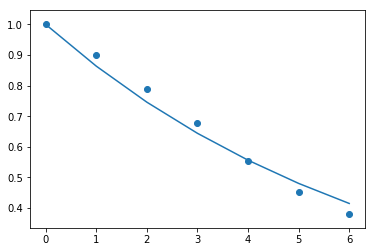

In [69]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(7)
plt.scatter(nt, cor_n8ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n8ace))

## N = 10 acetone

In [70]:
n10_plga_ace = mda.Universe("n10_plga_50ns/1_xa_soln/confout.gro", "n10_plga_50ns/1_xa_soln/nopbc_n10ace.xtc")

In [71]:
n10_plga_ace

<Universe with 25153 atoms>

In [72]:
len(n10_plga_ace.trajectory)

5001

In [73]:
poly_n10_ace = n10_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [74]:
com_bond_n10ace = np.zeros(shape=(1,5000))
count = 0
for ts in n10_plga_ace.trajectory[0:5000]:
    n10_mon1 = n10_plga_ace.select_atoms("resid 1")
    n10_mon2 = n10_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1.center_of_mass(), n10_mon2.center_of_mass(), 
                                                   box=n10_plga_ace.trajectory.ts.dimensions)
    com_bond_n10ace[0, count] = oo_len
    count += 1
lb_avg_n10ace = np.mean(com_bond_n10ace)

In [75]:
lb_avg_n10ace

5.9959741164262175

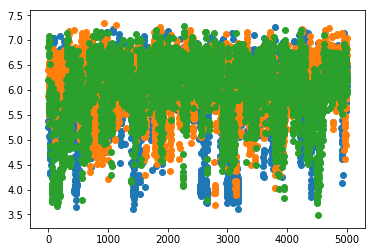

In [76]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)

In [77]:
n10_blks_ace = bavg_pers_cnt(5, poly_n10_ace, n10_plga_ace, lb_avg_n10ace, 0 , 5000)

0
1000
1000
2000
2000
3000
3000
4000
4000
5000


In [78]:
n10_blks_ace["Avg persistence length"]

array([46.53979514, 35.71162196, 44.59369505, 59.39120651, 27.38493004])

In [79]:
n10_blks_ace["Avg Radius of gyration"]

array([12.13223409,  9.76487645, 11.63368646, 12.41502452, 10.89992716])

In [80]:
np.mean(n10_blks_ace["Avg persistence length"])

42.72424973972319

In [81]:
np.std(n10_blks_ace["Avg persistence length"])

10.773229205734367

In [83]:
np.mean(n10_blks_ace["Avg Radius of gyration"])

11.369149737453803

In [84]:
np.std(n10_blks_ace["Avg Radius of gyration"])

0.9528897180078538

In [85]:
n10_rgens_ace, cor_n10ace_mat, pers_n10ace, rg_avgn10ace = get_rg_pers_poly(poly_n10_ace, n10_plga_ace, 0, 5000, 
                                                                        lb_avg_n6ace)

In [86]:
cor_n10ace_mat

array([[ 1.        ,  0.8874232 ,  0.75854253,  0.65113326,  0.54437389,
         0.45284403,  0.4204897 ,  0.36856106,  0.30500271],
       [ 0.        , 27.07794813, 39.9899855 , 48.47883154, 55.86022893,
        61.74158408, 63.42878919, 66.19119905, 69.60447513],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        ]])

In [87]:
cor_n10ace_mat[0]

array([1.        , 0.8874232 , 0.75854253, 0.65113326, 0.54437389,
       0.45284403, 0.4204897 , 0.36856106, 0.30500271])

In [88]:
pers_n10ace

40.74507637631994

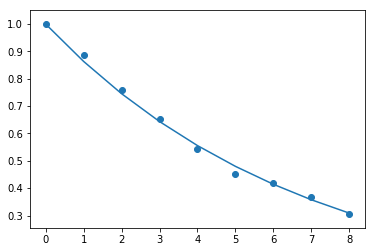

In [89]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(9)
plt.scatter(nt, cor_n10ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10ace))

## N = 20 acetone

In [90]:
n20_plga_ace = mda.Universe("n20_plga_150ns/1_xa_soln/1xa_n20sys.gro", "n20_plga_150ns/1_xa_soln/N20_nopbcpp_0xa.xtc")

In [91]:
n20_plga_ace

<Universe with 303 atoms>

In [92]:
len(n20_plga_ace.trajectory)

15001

In [93]:
poly_n20_ace = n20_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [94]:
com_bond_n20ace = np.zeros(shape=(1,5000))
count = 0
for ts in n20_plga_ace.trajectory[0:5000]:
    n20_mon1 = n20_plga_ace.select_atoms("resid 1")
    n20_mon2 = n20_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1.center_of_mass(), n20_mon2.center_of_mass(), 
                                                   box=n20_plga_ace.trajectory.ts.dimensions)
    com_bond_n20ace[0, count] = oo_len
    count += 1
lb_avg_n20ace = np.mean(com_bond_n20ace)

In [95]:
lb_avg_n20ace

5.932062741435674

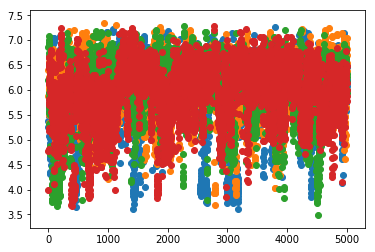

In [97]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)
plt.scatter(np.arange(5000),com_bond_n20ace)

In [98]:
n20_blks_ace = bavg_pers_cnt(5, poly_n20_ace, n20_plga_ace, lb_avg_n6ace, 0 , 15000)

0
3000
3000
6000
6000
9000
9000
12000
12000
15000


In [99]:
n20_blks_ace["Avg persistence length"]

array([40.76112529, 85.47596804, 46.598797  , 84.17099312, 69.80473716])

In [100]:
n20_blks_ace["Avg Radius of gyration"]

array([14.89197761, 20.14964338, 18.04132244, 18.868054  , 17.47107987])

In [101]:
np.mean(n20_blks_ace["Avg persistence length"])

65.36232412060328

In [102]:
np.std(n20_blks_ace["Avg persistence length"])

18.629807666741904

In [103]:
np.mean(n20_blks_ace["Avg Radius of gyration"])

17.884415460021938

In [104]:
np.std(n20_blks_ace["Avg Radius of gyration"])

1.746364950277481

In [105]:
n20_rgens_ace, cor_n20ace_mat, pers_n20ace, rg_avgn20ace = get_rg_pers_poly(poly_n20_ace, n20_plga_ace, 0, 15000, 
                                                                        lb_avg_n6ace)

In [106]:
cor_n20ace_mat

array([[ 1.        ,  0.89354871,  0.7664304 ,  0.657713  ,  0.5783637 ,
         0.51483595,  0.47047215,  0.43711494,  0.4134033 ,  0.38871389,
         0.37100197,  0.35375017,  0.34081105,  0.33434081,  0.3340146 ,
         0.32968601,  0.31597971,  0.28413062,  0.279729  ],
       [ 0.        , 26.48033803, 39.5871554 , 48.44687148, 54.2249732 ,
        58.52793586, 61.3718169 , 63.41725215, 64.82747309, 66.34118288,
        67.36156672, 68.26852668, 68.95688947, 69.26636078, 69.11796105,
        69.20257849, 69.67104242, 71.25395065, 70.67178099],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        , 10.        ,
        11.        , 12.        , 13.        , 14.        , 15.        ,
        16.        , 17.        , 18.        , 19.        ]])

In [107]:
cor_n20ace_mat[0]

array([1.        , 0.89354871, 0.7664304 , 0.657713  , 0.5783637 ,
       0.51483595, 0.47047215, 0.43711494, 0.4134033 , 0.38871389,
       0.37100197, 0.35375017, 0.34081105, 0.33434081, 0.3340146 ,
       0.32968601, 0.31597971, 0.28413062, 0.279729  ])

In [108]:
pers_n20ace

62.39290442313218

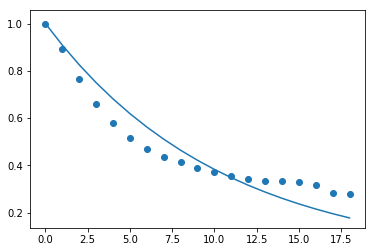

In [109]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(19)
plt.scatter(nt, cor_n20ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n20ace))

## N = 30 acetone

In [110]:
n30_plga_ace = mda.Universe("n30_plga_150ns/1_xa_soln/1xa_n30sys.gro", "n30_plga_150ns/1_xa_soln/N30_nopbcpp_1xa.xtc")

In [111]:
n30_plga_ace

<Universe with 453 atoms>

In [112]:
len(n30_plga_ace.trajectory)

15001

In [113]:
poly_n30_ace = n30_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [114]:
com_bond_n30ace = np.zeros(shape=(1,5000))
count = 0
for ts in n30_plga_ace.trajectory[0:5000]:
    n30_mon1 = n30_plga_ace.select_atoms("resid 1")
    n30_mon2 = n30_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1.center_of_mass(), n30_mon2.center_of_mass(), 
                                                   box=n30_plga_ace.trajectory.ts.dimensions)
    com_bond_n30ace[0, count] = oo_len
    count += 1
lb_avg_n30ace = np.mean(com_bond_n30ace)

In [115]:
lb_avg_n30ace

6.011313163610001

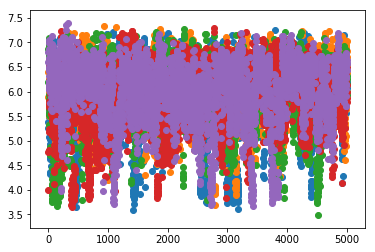

In [116]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)
plt.scatter(np.arange(5000),com_bond_n20ace)
plt.scatter(np.arange(5000),com_bond_n30ace)

In [117]:
n30_blks_ace = bavg_pers_cnt(5, poly_n30_ace, n30_plga_ace, lb_avg_n6ace, 0 , 15000)

0
3000
3000
6000
6000
9000
9000
12000
12000
15000


In [118]:
n30_blks_ace["Avg persistence length"]

array([ 41.86358329,  46.10146621,  38.69075482, 105.83686147,
        82.63083182])

In [119]:
n30_blks_ace["Avg Radius of gyration"]

array([21.37781682, 15.99548405, 14.58083745, 22.33585525, 18.66784321])

In [120]:
np.mean(n30_blks_ace["Avg persistence length"])

63.02469952436293

In [121]:
np.std(n30_blks_ace["Avg persistence length"])

26.62183752030562

In [122]:
np.mean(n30_blks_ace["Avg Radius of gyration"])

18.591567354387102

In [123]:
np.std(n30_blks_ace["Avg Radius of gyration"])

2.9871156246197934

In [124]:
n30_rgens_ace, cor_n30ace_mat, pers_n30ace, rg_avgn30ace = get_rg_pers_poly(poly_n30_ace, n30_plga_ace, 0, 15000, 
                                                                        lb_avg_n6ace)

In [125]:
cor_n30ace_mat

array([[ 1.        ,  0.87129401,  0.70613498,  0.59938159,  0.53558677,
         0.47354981,  0.41799197,  0.38087398,  0.3442499 ,  0.30996957,
         0.28505719,  0.27321975,  0.26637246,  0.24944217,  0.23485888,
         0.22061014,  0.214439  ,  0.20568275,  0.19880694,  0.200682  ,
         0.22671252,  0.24252012,  0.23938647,  0.23573596,  0.24334063,
         0.24887517,  0.25021708,  0.25486757,  0.25109415],
       [ 0.        , 29.23717463, 44.81667128, 52.96412667, 57.42273995,
        61.54736467, 65.10819607, 67.39755031, 69.66338936, 71.76408903,
        73.25741299, 73.92670425, 74.28917916, 75.24861078, 76.04564677,
        76.8267799 , 77.12665094, 77.5929367 , 77.94242184, 77.81027518,
        76.25011706, 75.20456241, 75.36678008, 75.58089752, 74.9703761 ,
        74.38107625, 74.13115978, 73.45904092, 72.84638795],
       [ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        , 10.        ,
  

In [126]:
cor_n30ace_mat[0]

array([1.        , 0.87129401, 0.70613498, 0.59938159, 0.53558677,
       0.47354981, 0.41799197, 0.38087398, 0.3442499 , 0.30996957,
       0.28505719, 0.27321975, 0.26637246, 0.24944217, 0.23485888,
       0.22061014, 0.214439  , 0.20568275, 0.19880694, 0.200682  ,
       0.22671252, 0.24252012, 0.23938647, 0.23573596, 0.24334063,
       0.24887517, 0.25021708, 0.25486757, 0.25109415])

In [127]:
pers_n30ace

58.434266746484155

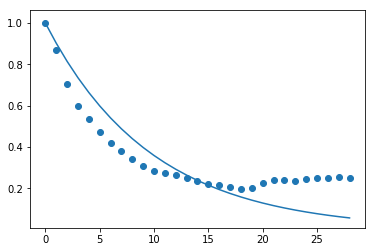

In [129]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(29)
plt.scatter(nt, cor_n30ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n30ace))